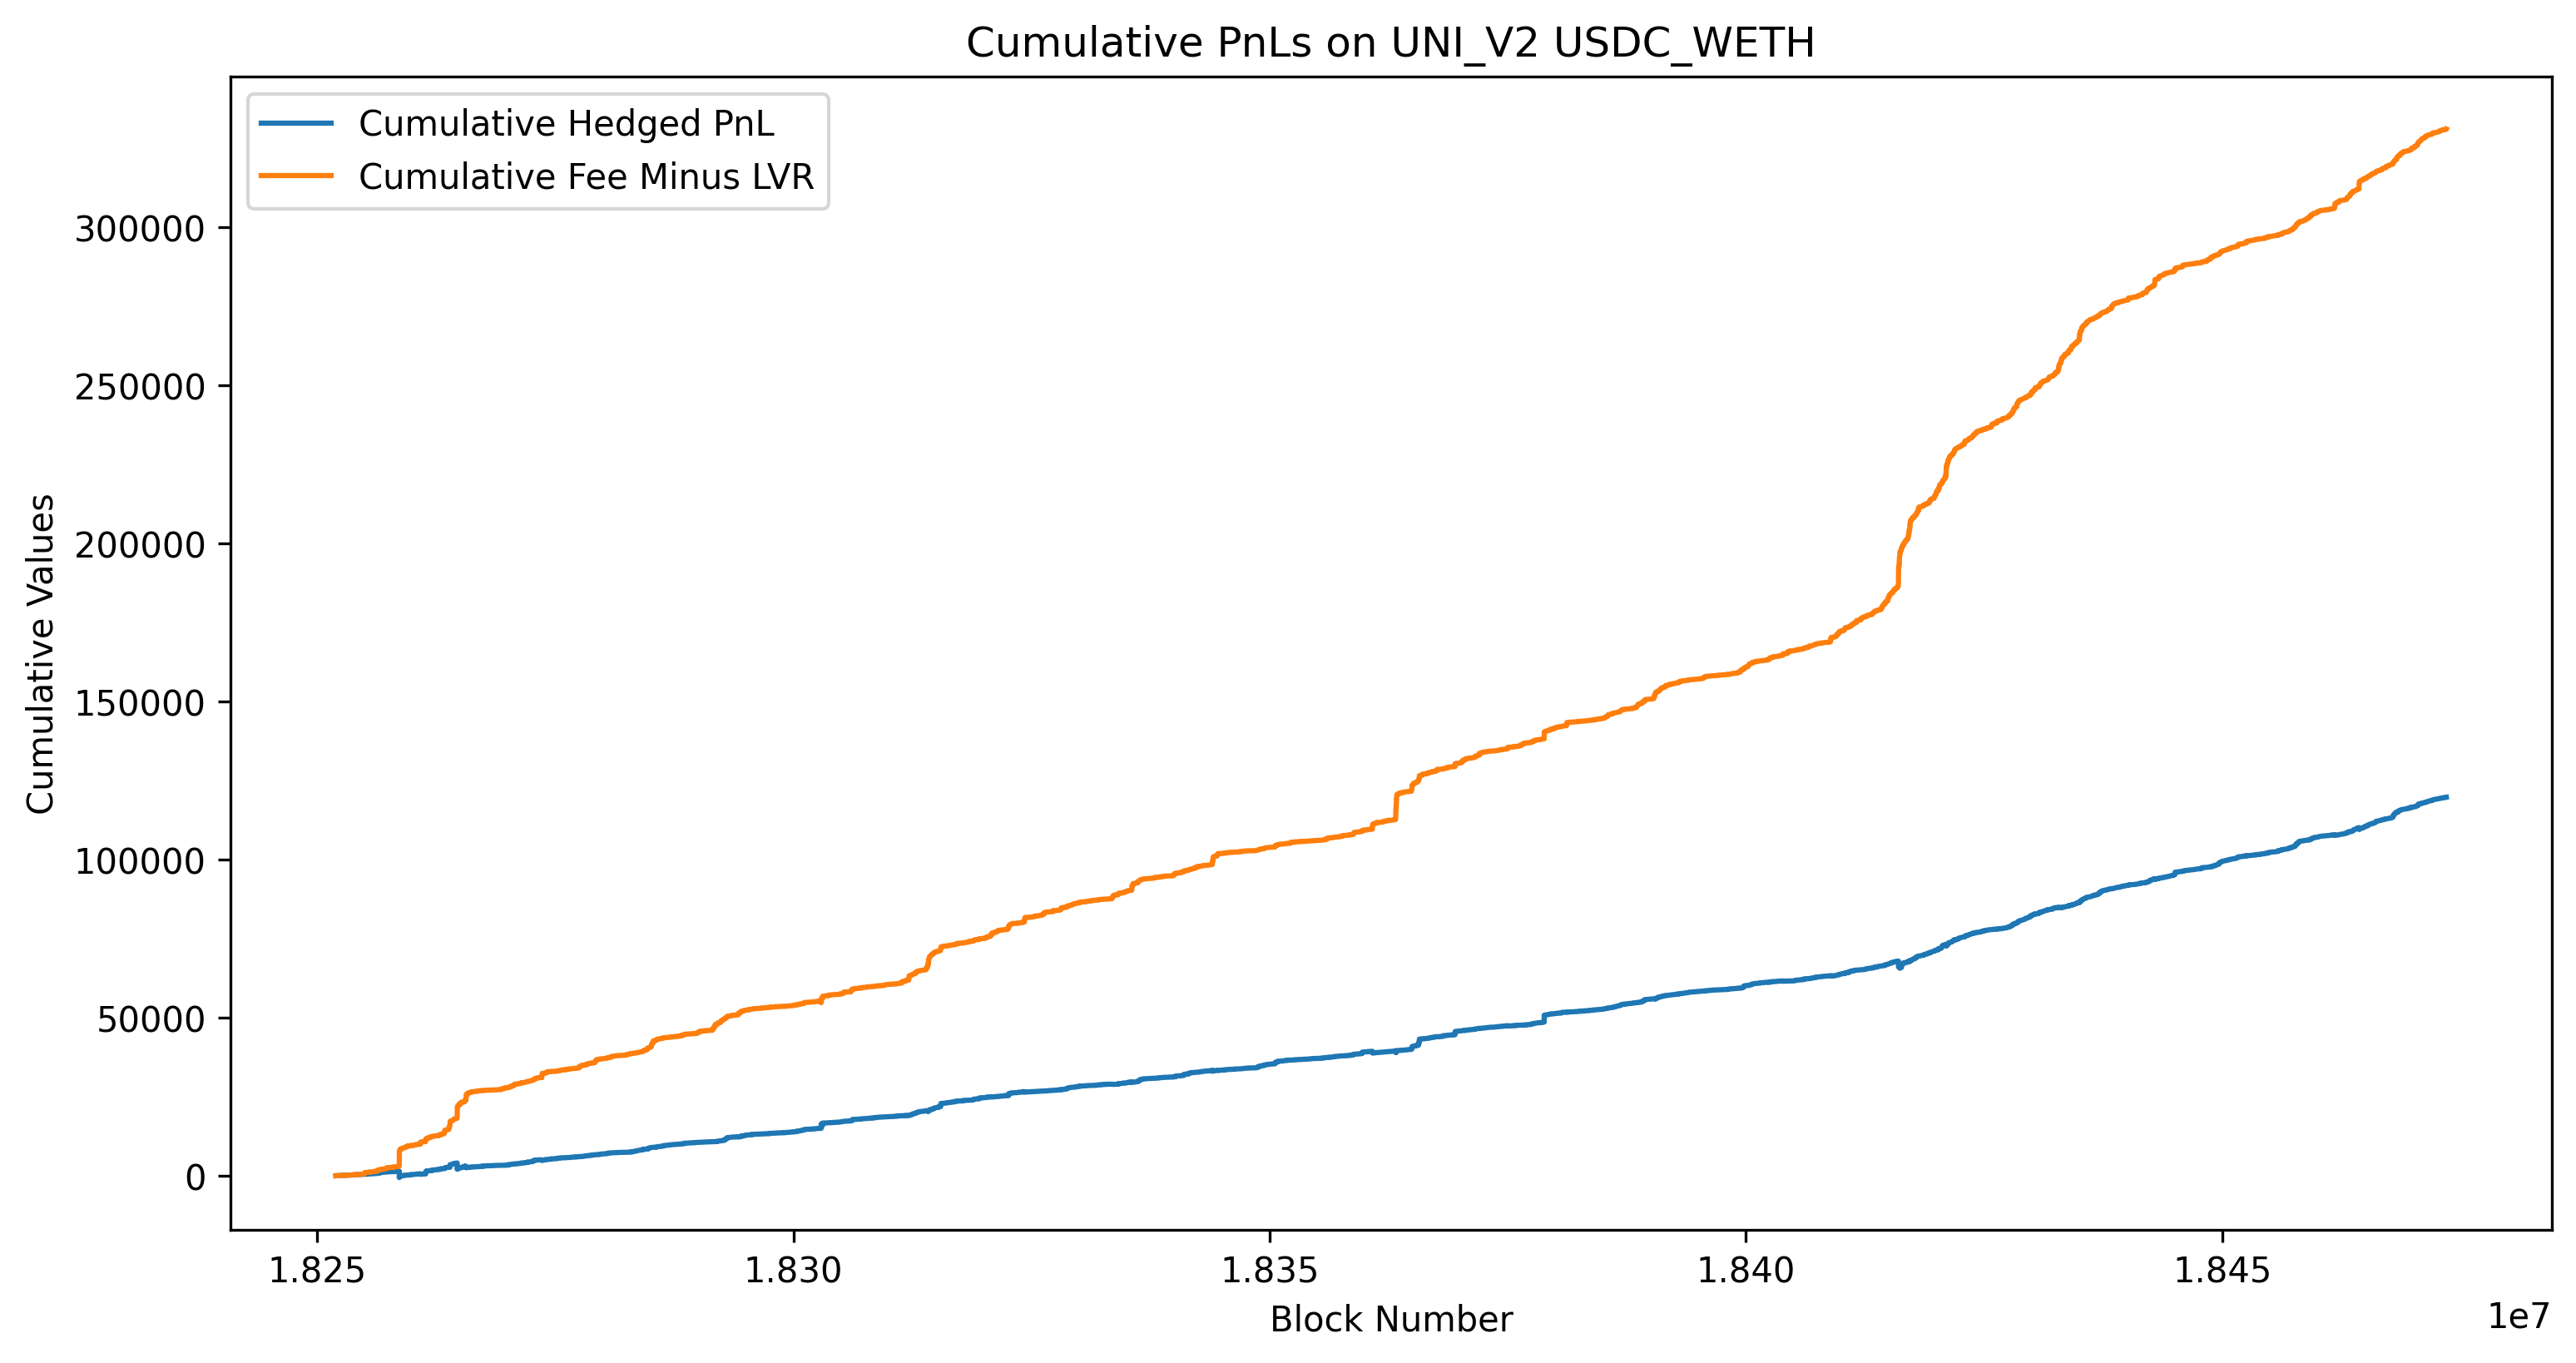

In [2]:
from dotenv import load_dotenv
import os
import web3
from datetime import datetime, timezone
from utils import *
from decimal import Decimal
import pandas as pd
import time
import matplotlib.pyplot as plt

load_dotenv()

DEX = "UNI_V2"
PAIR = "USDC_WETH"

# generate DataFrame from csv
blocks_df = pd.read_csv("data/blocks/timestamp_blockNumber_baseFeePerGas.csv")
cex_prices_df = pd.read_csv("data/cex_price/ETHUSDC-1s-2023-10-opens.csv")
syncs_df = (
    pd.read_csv(f"data/onchain_events/{DEX}_{PAIR}_syncs.csv")
    .drop_duplicates(subset="blockNumber", keep="last")
    .reset_index(drop=True)
)  # take the last values of each block
swaps_df = (
    pd.read_csv(f"data/onchain_events/{DEX}_{PAIR}_swaps.csv")
    .groupby("blockNumber", as_index=False)
    .sum()
)  # sum up all the swaps in block
mints_df = (
    pd.read_csv(f"data/onchain_events/{DEX}_{PAIR}_mints.csv")
    .groupby("blockNumber", as_index=False)
    .sum()
)  # sum up all the mints in block
burns_df = (
    pd.read_csv(f"data/onchain_events/{DEX}_{PAIR}_burns.csv")
    .groupby("blockNumber", as_index=False)
    .sum()
)  # sum up all the burns in block

# divide the amounts by 10**decimals
# beware of the token numbers!
syncs_df["reserve0"] /= 10**6
syncs_df["reserve1"] /= 10**18

swaps_df["amount0In"] /= 10**6
swaps_df["amount0Out"] /= 10**6
swaps_df["amount1In"] /= 10**18
swaps_df["amount1Out"] /= 10**18

mints_df["amount0Minted"] /= 10**6
mints_df["amount1Minted"] /= 10**18

burns_df["amount0Burnt"] /= 10**6
burns_df["amount1Burnt"] /= 10**18

# construct the main df
df = blocks_df
df = pd.merge(df, cex_prices_df, on="timestamp", how="left")
df = pd.merge(df, syncs_df, on="blockNumber", how="left")
df = pd.merge(df, swaps_df, on="blockNumber", how="left")
df = pd.merge(df, mints_df, on="blockNumber", how="left")
df = pd.merge(df, burns_df, on="blockNumber", how="left")
df.fillna(0.0, inplace=True)
for i in range(1, len(df)):
    if df.at[i, "reserve0"] == 0.0:
        df.at[i, "reserve0"] = df.at[i - 1, "reserve0"]
    if df.at[i, "reserve1"] == 0.0:
        df.at[i, "reserve1"] = df.at[i - 1, "reserve1"]

# compute mintValue, burnValue, poolValue, poolPnL, rebalancingStrategyPnL, feeEarned, traderPnL, LVR
df["mintValue"] = df["amount0Minted"] + df["amount1Minted"] * df["price"]
df["burnValue"] = df["amount0Burnt"] + df["amount1Burnt"] * df["price"]
df["poolValue"] = df["reserve0"] + df["reserve1"] * df["price"]
df["poolPnL"] = (
    df["poolValue"] + df["burnValue"] - df["mintValue"] - df["poolValue"].shift(1)
)
df["rebalancingStrategyPnL"] = df["reserve1"].shift(1) * (
    df["price"] - df["price"].shift(1)
)

df["feeEarned"] = 0.003 * (df["amount0In"] + df["amount1In"] * df["price"])
df["traderPnL"] = (df["amount0Out"] + df["amount1Out"] * df["price"]) - (
    df["amount0In"] + df["amount1In"] * df["price"]
) * 0.997
df["LVR"] = -df["traderPnL"]
df.fillna(0.0, inplace=True)

# Calculate cumulative sums
df["cum_poolPnL"] = df["poolPnL"].cumsum()
df["cum_rebalancingStrategyPnL"] = df["rebalancingStrategyPnL"].cumsum()
df["cum_feeEarned"] = df["feeEarned"].cumsum()
df["cum_traderPnL"] = df["traderPnL"].cumsum()
df["cum_LVR"] = df["LVR"].cumsum()

# Plotting
plt.figure(figsize=(12, 6), dpi=300)

# Plot each cumulative column
plt.plot(
    df["blockNumber"],
    df["cum_poolPnL"] - df["cum_rebalancingStrategyPnL"],
    label="Cumulative Hedged PnL",
)
plt.plot(
    df["blockNumber"],
    df["cum_feeEarned"] - df["cum_LVR"],
    label="Cumulative Fee Minus LVR",
)

# Adding labels and title
plt.xlabel("Block Number")
plt.ylabel("Cumulative Values")
plt.title(f"Cumulative PnLs on {DEX} {PAIR}")
plt.legend()

# Save figure
plt.savefig(f"results/cum_PnLs_{DEX}_{PAIR}.png", dpi=300)

# Show the plot
plt.show()